# Dataset Loading and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/MyDrive/large-dataset-cleaned.zip
!unzip /content/drive/MyDrive/casia-webface-final.zip

In [ ]:
!ls

In [ ]:
import os

base_dir = 'casia-webface-final'
train_celebs = os.listdir(base_dir)
print(train_celebs[:10])

In [ ]:
print('Training Images: ', len(train_celebs))

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0

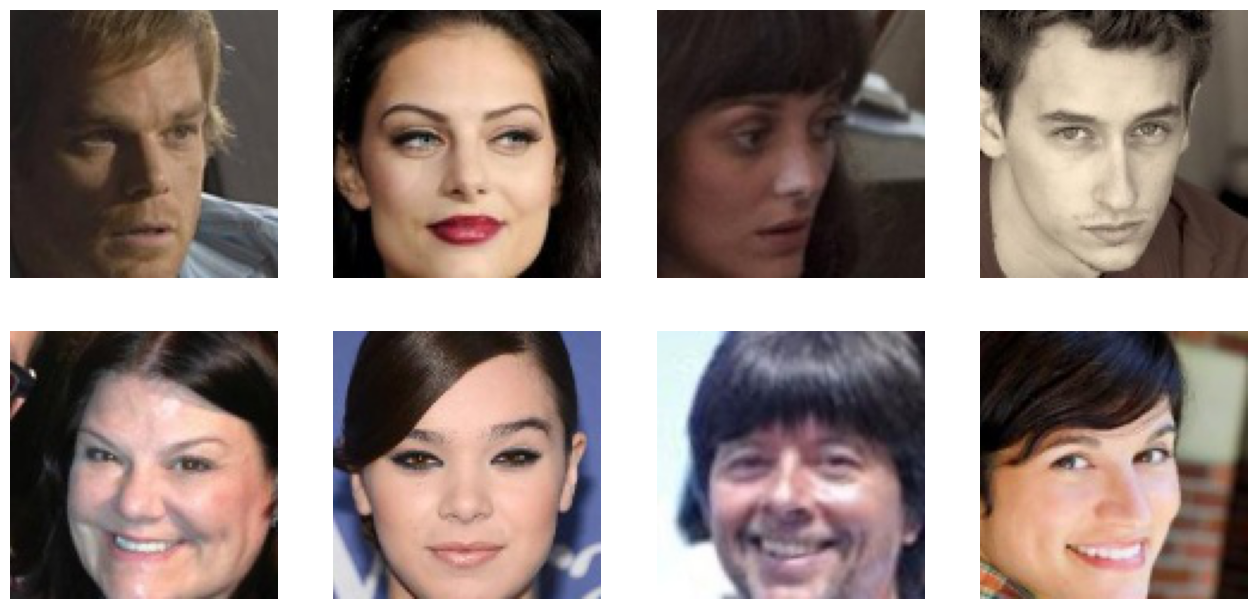

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_celeb_pix = [os.path.join(base_dir, fname) 
                for fname in train_celebs[pic_index-8:pic_index]]


for i, img_path in enumerate(next_celeb_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import mean_squared_error
import tensorflow as tf

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

In [ ]:
import tensorflow as tf
from tensorflow.image import ssim

def ssim_loss(y_true, y_pred):
    return 1 - ssim(y_true, y_pred, max_val=255.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

data_dir = ""
img_size = (64, 64)
num_channels = 3
file_ext = ".jpg"

class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size, img_size, num_channels, file_ext, shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_channels = num_channels
        self.file_ext = file_ext
        self.shuffle = shuffle
        self.file_names = [f for f in os.listdir(self.data_dir) if f.endswith(self.file_ext)]
        self.file_names.sort()
        self.indexes = np.arange(len(self.file_names))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.file_names) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_data = np.zeros((len(batch_indexes), self.img_size[0], self.img_size[1], self.num_channels), dtype=np.float32)
        for i, batch_idx in enumerate(batch_indexes):
            file_name = self.file_names[batch_idx]
            img = Image.open(os.path.join(self.data_dir, file_name))
            img = img.resize(self.img_size)
            img = np.array(img, dtype=np.float32) / 255.0
            batch_data[i] = img
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_gen = ImageDataGenerator(data_dir+'casia-webface-final', batch_size=512, img_size=img_size, num_channels=num_channels, file_ext=file_ext)
test_gen = ImageDataGenerator(data_dir+'test', batch_size=512, img_size=img_size, num_channels=num_channels, file_ext=file_ext)

# Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/model-checkpoints/new_new_model_checkpoint_{epoch:02d}.h5"

checkpoint = ModelCheckpoint(filepath, save_freq='epoch')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# CNN Autoencoder (CAE)

In [ ]:
zdim = 64

encoder = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=(64, 64, 3)),
        layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Flatten(),
        layers.Dense(units=zdim)
    ]
)


decoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=(zdim,)),
        tf.keras.layers.Dense(units=1024*8*8),
        tf.keras.layers.Reshape((8, 8, 1024)),
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=1, strides=1, padding='valid', activation=None),
    ]
)

encoder.compile()
encoder.summary()

decoder.compile()
decoder.summary()

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss='mse')

autoencoder.fit(
    train_gen,
    epochs=5,
    steps_per_epoch=455595 // 512,  # total_num_of_train_images / batch_size
    validation_data=test_gen,
    validation_steps=0 // 512,  # total_num_of_test_images / batch_size
    callbacks=[checkpoint],
)

# Adversarial Autoencoder

In [ ]:
zdim = 128

encoder = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=(64, 64, 3)),
        layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Flatten(),
        layers.Dense(units=zdim)
    ]
)


decoder = tf.keras.Sequential([
        layers.InputLayer(input_shape=(zdim,)),
        tf.keras.layers.Dense(units=1024*8*8),
        tf.keras.layers.Reshape((8, 8, 1024)),
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=1, strides=1, padding='valid', activation=None),
    ]
)

discriminator = tf.keras.Sequential([
     layers.InputLayer(input_shape=(zdim,)),
      tf.keras.layers.Dense(units=512),
      tf.keras.layers.Dense(units=512),
      tf.keras.layers.Dense(units=512),
      tf.keras.layers.Dense(units=512),
      tf.keras.layers.Dense(units=1),
  ]
)

encoder.compile()
encoder.summary()

decoder.compile()
decoder.summary()

discriminator.compile()
discriminator.summary()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse_loss = tf.keras.losses.MeanSquaredError()

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

batch_size = 512
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i, x_real in enumerate(train_gen):        
        with tf.GradientTape() as tape:
            z = encoder(x_real[0], training=True)
            
            x_fake = decoder(z, training=True)
            
            d_real = discriminator(z, training=True)
            d_fake = discriminator(tf.random.normal(shape=(batch_size, zdim)), training=True)
            disc_loss_real = cross_entropy(tf.ones_like(d_real), d_real)
            disc_loss_fake = cross_entropy(tf.zeros_like(d_fake), d_fake)
            disc_loss = disc_loss_real + disc_loss_fake
            
        disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        
        with tf.GradientTape() as tape:
            z = tf.random.normal(shape=(batch_size, zdim))
            x_fake = decoder(z, training=True)
            
            z_fake = encoder(x_fake, training=True)
            
            g_loss = mse_loss(x_fake, x_real) + cross_entropy(tf.ones_like(d_fake), discriminator(z_fake, training=True))
        
        gen_grads = tape.gradient(g_loss, encoder.trainable_variables + decoder.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables + decoder.trainable_variables))
        
        if (i+1) % 10 == 0:
            print(f"Batch {i+1}: Discriminator loss = {disc_loss.numpy():.4f}, Generator loss = {g_loss.numpy():.4f}")

In [17]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

autoencoder = load_model("/content/drive/MyDrive/new_new_model_checkpoint_01.h5", compile=False)
encoder = autoencoder.get_layer('sequential_3')
decoder = autoencoder.get_layer('sequential_4')
encoder.compile()
decoder.compile()
autoencoder.compile()

# Variational Autoencoder (VAE)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

zdim = 128

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], zdim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder network
encoder_inputs = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False)(encoder_inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=1024, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(units=zdim, name='z_mean')(x)
z_log_var = layers.Dense(units=zdim, name='z_log_var')(x)

z = layers.Lambda(sampling, output_shape=(zdim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = layers.Input(shape=(zdim,), name='z_sampling')
x = layers.Dense(units=1024*8*8)(latent_inputs)
x = layers.Reshape((8, 8, 1024))(x)
x = layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.Activation('relu')(x)
decoder_outputs = layers.Conv2DTranspose(filters=3, kernel_size=1, strides=1, padding='valid', activation=None)(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')

reconstruction_loss = tf.keras.losses.mse(K.flatten(encoder_inputs), K.flatten(outputs))
reconstruction_loss *= 64 * 64 * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

lr = 0.0002
optimizer = Adam(lr=lr)

vae.compile(optimizer=optimizer)

vae.fit(
    train_gen,
    epochs=5,
    steps_per_epoch=455595 // 512,  # total_num_of_train_images / batch_size
    validation_data=test_gen,
    validation_steps=0 // 512,  # total_num_of_test_images / batch_size
    callbacks=[checkpoint],
)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  6144        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 256)  524288      ['activation[0][0]']             
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Evaluation and Analysis

In [2]:
import os
import numpy as np
from PIL import Image

data_dir = ""

img_size = (64, 64)
num_channels = 3

file_ext = ".jpeg"

def load_data(data_dir):
    file_names = [f for f in os.listdir(data_dir) if f.endswith(file_ext)]
    file_names.sort()
    images = np.zeros((len(file_names), img_size[0], img_size[1], num_channels), dtype=np.float32)
    for i, file_name in enumerate(file_names):
        img = Image.open(os.path.join(data_dir, file_name))
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        images[i] = img
    return images

x_manual = load_data('manual')

In [ ]:
import pickle
with open('/content/drive/MyDrive/cnn-casia-webface-vae-64-5epochs-bhaswara-rgb.pkl', 'wb') as f:
  pickle.dump(encoder, f)

In [11]:
#test_embeddings = encoder.predict(x_manual[:50])[2] for VAE
test_embeddings = vae_model.predict(x_manual[:50])[2]
test_embeddings.shape

2/2 [==============================] - 0s 16ms/step


(50, 128)

## ROC Curves

In [8]:
import pickle

with open('casia-cnn-128.pkl', 'rb') as f:
    cnn_model = pickle.load(f)

with open('/content/drive/MyDrive/vae_encoder_128dim.pkl', 'rb') as f:
    vae_model = pickle.load(f)

with open('casia-aae-128.pkl', 'rb') as f:
    ae_model = pickle.load(f)

cnn_test_embeddings = cnn_model.predict(x_manual)
vae_test_embeddings = vae_model.predict(x_manual[:50])[2]
ae_test_embeddings = ae_model.predict(x_manual)

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[109.88603210449219, 109.44784545898438, 126.42523956298828, 125.83953094482422, 113.36695098876953, 106.91558837890625, 117.93780517578125, 121.77118682861328, 142.1877899169922, 185.1540069580078, 170.78170776367188, 158.9373321533203, 176.73423767089844, 157.00730895996094, 156.75624084472656, 150.44200134277344, 152.73948669433594, 154.79959106445312, 153.63243103027344, 120.03570556640625, 109.9503402709961, 124.67901611328125, 118.84077453613281, 136.9553985595703, 130.93556213378906, 129.3673858642578, 117.74421691894531, 115.35710144042969, 144.78407287597656, 155.14187622070312, 127.30345153808594, 144.20489501953125, 148.86582946777344, 151.3014373779297, 130.17877197265625, 145.80398559570312, 143.5771026611328, 156.8953857421875, 138.6818389892578, 148.71029663085938, 128.78392028808594, 122.12834167480469, 132.75326538085938, 129.0513153076172, 139.61337280273438, 129.1960906982422, 114.85110473632812, 115.75447082519531, 120.34761047363281, 89.61693572998047, 99.964591979

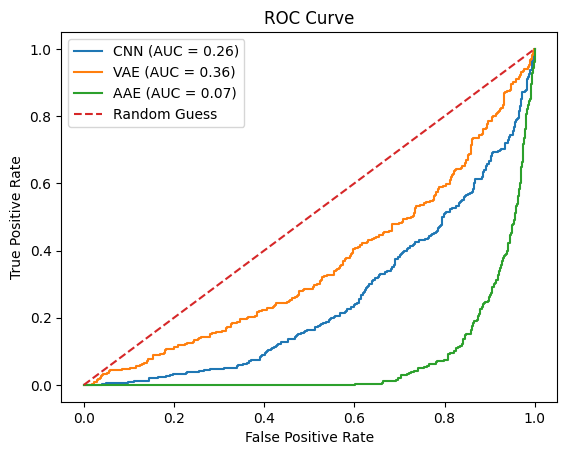

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import SpectralClustering

num_clusters = len(x_manual) // 10

kmeans=KMeans(n_clusters=5, random_state=0)
#spec = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
# cnn_cluster_labels = spec.fit(cnn_test_embeddings).labels_
# vae_cluster_labels = spec.fit(vae_test_embeddings).labels_
# ae_cluster_labels = spec.fit(ae_test_embeddings).labels_
cnn_cluster_labels = kmeans.fit_predict(cnn_test_embeddings)
vae_cluster_labels = kmeans.fit_predict(vae_test_embeddings)
ae_clusters_labels = kmeans.fit_predict(ae_test_embeddings)

cnn_distances = np.zeros((len(x_manual), len(x_manual)))
vae_distances = np.zeros((len(x_manual), len(x_manual)))
ae_distances = np.zeros((len(x_manual), len(x_manual)))

for i in range(len(x_manual)):
    for j in range(len(x_manual)):
        cnn_distances[i, j] = np.linalg.norm(cnn_test_embeddings[i] - cnn_test_embeddings[j])
        vae_distances[i, j] = np.linalg.norm(vae_test_embeddings[i] - vae_test_embeddings[j])
        ae_distances[i, j] = np.linalg.norm(ae_test_embeddings[i] - ae_test_embeddings[j])


cnn_scores = []
vae_scores = []
ae_scores = []
cnn_true_labels = []
vae_true_labels = []
ae_true_labels = []
for i in range(len(x_manual)):
    for j in range(i + 1, len(x_manual)):
        cnn_scores.append(cnn_distances[i, j])
        vae_scores.append(vae_distances[i, j])
        ae_scores.append(ae_distances[i, j])
        if cnn_cluster_labels[i] == cnn_cluster_labels[j]:
            cnn_true_labels.append(1)
        else:
            cnn_true_labels.append(0)
        if vae_cluster_labels[i] == vae_cluster_labels[j]:
            vae_true_labels.append(1)
        else:
            vae_true_labels.append(0)
        if ae_clusters_labels[i] == ae_clusters_labels[j]:
            ae_true_labels.append(1)
        else:
            ae_true_labels.append(0)

print(cnn_scores)

cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(cnn_true_labels, cnn_scores)
cnn_auc = auc(cnn_fpr, cnn_tpr)
vae_fpr, vae_tpr, vae_thresholds = roc_curve(vae_true_labels, vae_scores)
vae_auc = auc(vae_fpr, vae_tpr)
ae_fpr, ae_tpr, ae_thresholds = roc_curve(ae_true_labels, ae_scores)
ae_auc = auc(ae_fpr, ae_tpr)

# Plot the ROC curve
plt.plot(cnn_fpr, cnn_tpr, label='CNN (AUC = {:.2f})'.format(cnn_auc))
plt.plot(vae_fpr, vae_tpr, label='VAE (AUC = {:.2f})'.format(vae_auc))
plt.plot(ae_fpr, ae_tpr, label='AAE (AUC = {:.2f})'.format(ae_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


2/2 [==============================] - 0s 80ms/step


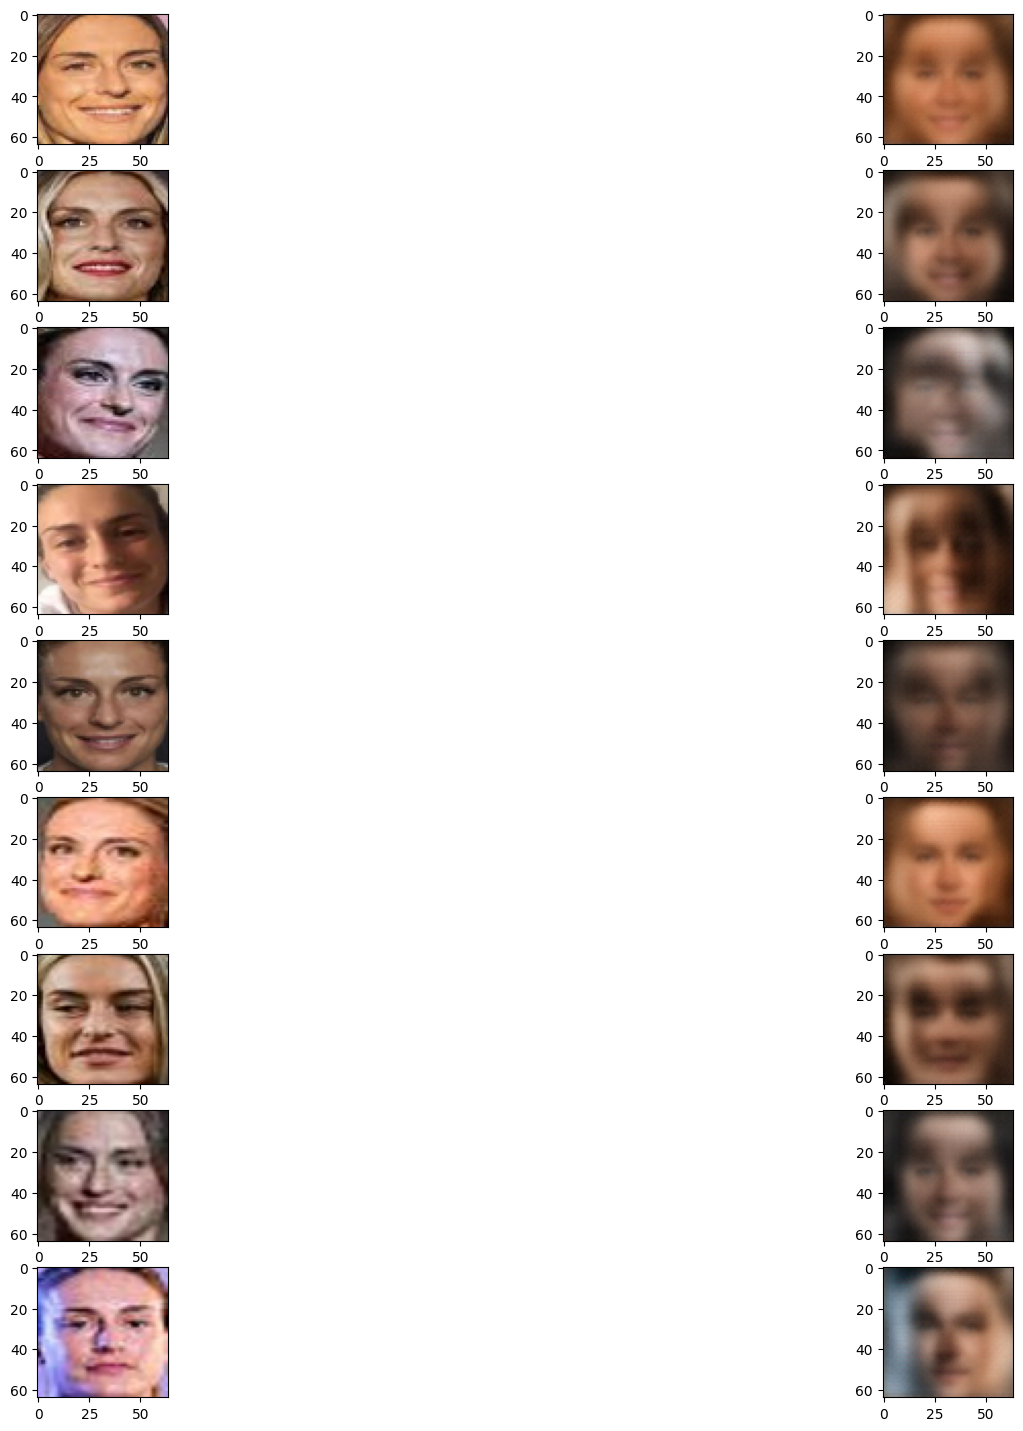

In [18]:
import matplotlib.pyplot as plt
reconstructed = autoencoder.predict(x_manual)
fig=plt.figure(figsize=(20, 20))
for i in range(1, 10):
    fig.add_subplot(10, 2, 2 * i - 1)
    plt.imshow(x_manual[i])
    fig.add_subplot(10, 2, 2 * i)
    plt.imshow(reconstructed[i])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(embedding1, embedding2):
    embedding1 = np.reshape(embedding1, (-1,))
    embedding2 = np.reshape(embedding2, (-1,))
    
    similarity = cosine_similarity(embedding1.reshape(1,-1), embedding2.reshape(1,-1))[0][0]
    
    return similarity


for y in range(10):
  print(calculate_similarity(test_embeddings[5], test_embeddings[y]))

0.32811797
0.5522442
0.6265654
0.65380794
0.30953172
1.0
0.44264483
0.64316714
0.7466991
0.26422304


## K-Means Clustering

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)

kmeans = KMeans(n_clusters=5, random_state=0)

kmeans.fit(data_2d)

labels = kmeans.predict(data_2d)

for i, label in enumerate(labels):
    print(label, end=' ')
    if (i + 1) % 10 == 0:
        print('')

4 4 4 4 1 4 1 1 4 1 
0 0 0 0 0 0 0 0 0 0 
1 4 4 1 4 4 1 4 4 4 
2 3 2 2 2 4 4 2 2 4 
1 1 4 4 1 3 1 1 4 1 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Affinity Propagation

In [ ]:
import numpy as np
from sklearn.cluster import AffinityPropagation

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)
print(data_2d.shape)

affinity_propagation = AffinityPropagation(random_state=0, max_iter=10000, damping=0.5)

affinity_propagation.fit(data_2d)

#labels = affinity_propagation.predict(data_2d)

labels = affinity_propagation.labels_

for i, label in enumerate(labels):
    print(label, end=' ')
    if (i + 1) % 10 == 0:
        print('')

(50, 64)
1 0 4 0 0 1 0 0 0 0 
4 2 2 2 2 2 5 1 1 3 
4 0 5 1 4 4 5 0 1 3 
3 4 4 1 3 1 5 4 3 3 
1 5 0 5 5 4 1 5 1 1 


## Spectral Clustering

In [ ]:
import numpy as np
from sklearn.cluster import SpectralClustering

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)

n_clusters=5

spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')

spectral_clustering.fit(data_2d)

labels = spectral_clustering.labels_

for i, label in enumerate(labels):
    print(label, end=' ')
    if (i + 1) % 10 == 0:
        print('')


2 4 4 4 0 3 4 0 2 4 
4 1 1 1 1 1 3 1 1 1 
2 4 2 2 1 2 2 4 2 4 
3 3 3 3 3 2 3 3 3 4 
0 0 4 0 0 3 0 0 0 0 


## Gaussian Mixture Model (GMM)

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)

gmm = GaussianMixture(n_components=5, random_state=0)

gmm.fit(data_2d)

labels = gmm.predict(data_2d)

for i, label in enumerate(labels):
    print(label, end=' ')
    if (i + 1) % 10 == 0:
        print('')

2 3 3 3 4 3 2 0 3 0 
1 1 1 1 1 1 4 1 1 1 
0 3 3 2 3 3 3 2 3 2 
4 4 4 4 4 0 1 4 1 0 
4 0 0 0 0 0 0 0 0 3 


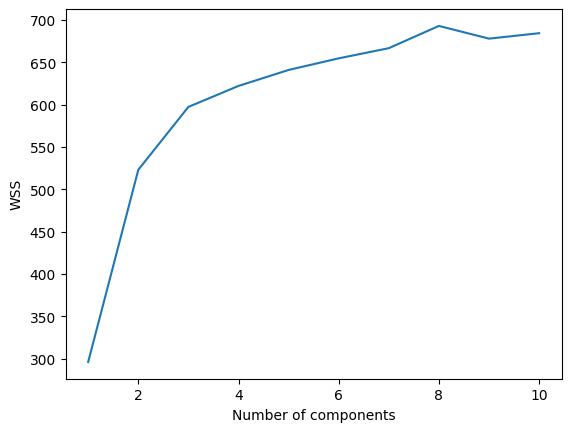

Elbow point at 8 components


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)

wss = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data_2d)
    wss.append(gmm.score(data_2d))

plt.plot(n_components_range, wss)
plt.xlabel('Number of components')
plt.ylabel('WSS')
plt.show()

# Find the elbow point
diffs = np.diff(wss)
diffs2 = np.diff(diffs)
elbow_index = np.argmax(diffs2) + 1

print("Elbow point at %d components" % elbow_index)

## Agglomerative Clustering

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

n_samples = test_embeddings.shape[0]
n_features = np.prod(test_embeddings.shape[1:])
data_2d = test_embeddings.reshape(n_samples, n_features)

agglomerative_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=3)

labels = agglomerative_clustering.fit_predict(data_2d)

for i, label in enumerate(labels):
    print(label, end=' ')
    if (i + 1) % 10 == 0:
        print('')


27 44 39 35 31 43 36 30 29 47 
21 25 40 41 38 14 45 32 19 15 
37 33 34 16 42 28 48 49 23 24 
11 20 17 46 18 22 8 7 13 10 
9 26 12 6 4 3 1 5 2 0 


## Cluster Visualization

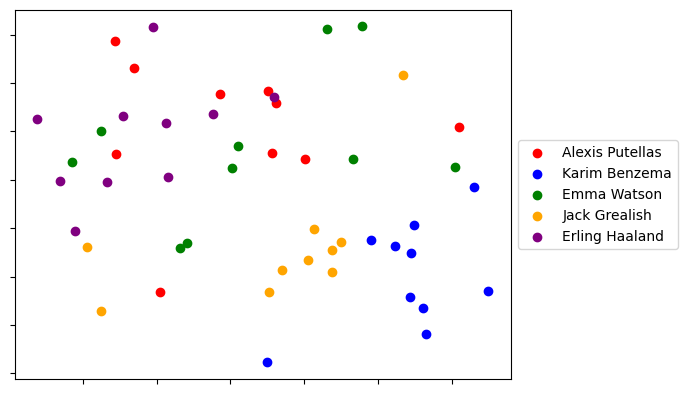

In [12]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = test_embeddings

embeddings = embeddings.reshape(embeddings.shape[0], -1)

num_clusters = 5
images_per_cluster = 10

cluster_labels = np.repeat(np.arange(num_clusters), images_per_cluster)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

colors = ['red', 'blue', 'green', 'orange', 'purple']

labels = ['Alexis Putellas', 'Karim Benzema', 'Emma Watson', 'Jack Grealish', 'Erling Haaland']

fig, ax = plt.subplots()
ax.set_yticklabels([])
ax.set_xticklabels([])
for i in range(num_clusters):
    start_idx = i * images_per_cluster
    end_idx = (i + 1) * images_per_cluster
    ax.scatter(embeddings_tsne[start_idx:end_idx, 0],
               embeddings_tsne[start_idx:end_idx, 1],
               c=colors[i],
               label=f'{labels[i]}')
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()